# Exploratory Data Analysis

The objective is to inspect the data, get general understanding of the datasets, check for patterns, understand what preprocessing should be done before the modeling.


The dataset contains a README file with a very good descriptions - let's print it out here:

In [1]:
try:
    with open("CMAPSSData/readme.txt", "r", encoding="utf-8") as f:
        content = f.read()
except UnicodeDecodeError:
    with open("CMAPSSData/readme.txt", "r", encoding="cp1252") as f:
        content = f.read()

print(content)

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)



Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. Th

# Now the aim is to get some great understanding of the dataset, through visualization

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os

%matplotlib inline

In [3]:
files = os.listdir("CMAPSSData")
print("\n".join(files))

6. Turbofan Engine Degradation Simulation Data Set
Damage Propagation Modeling.pdf
readme.txt
RUL_FD001.txt
RUL_FD002.txt
RUL_FD003.txt
RUL_FD004.txt
test_FD001.txt
test_FD002.txt
test_FD003.txt
test_FD004.txt
train_FD001.txt
train_FD002.txt
train_FD003.txt
train_FD004.txt


In [4]:


print(f"\n=== Quick overview of the 2 first line of the FD001 data set ===")

print(f"\n=== TRAIN SET ===")
with open("CMAPSSData/train_FD001.txt", "r", encoding="cp1252") as f:
    for _ in range(2):
        print(f.readline(), end="")
print(f"\n========================")

print(f"\n=== TEST SET ===")
with open("CMAPSSData/test_FD001.txt", "r", encoding="cp1252") as f:
    for _ in range(2):
        print(f.readline(), end="")
print(f"\n========================")


=== Quick overview of the 2 first line of the FD001 data set ===

=== TRAIN SET ===
1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.30 47.47 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100.00 39.06 23.4190  
1 2 0.0019 -0.0003 100.0 518.67 642.15 1591.82 1403.14 14.62 21.61 553.75 2388.04 9044.07 1.30 47.49 522.28 2388.07 8131.49 8.4318 0.03 392 2388 100.00 39.00 23.4236  


=== TEST SET ===
1 1 0.0023 0.0003 100.0 518.67 643.02 1585.29 1398.21 14.62 21.61 553.90 2388.04 9050.17 1.30 47.20 521.72 2388.03 8125.55 8.4052 0.03 392 2388 100.00 38.86 23.3735  
1 2 -0.0027 -0.0003 100.0 518.67 641.71 1588.45 1395.42 14.62 21.61 554.85 2388.01 9054.42 1.30 47.50 522.16 2388.06 8139.62 8.3803 0.03 393 2388 100.00 39.02 23.3916  



# Label the data based on the README file :

In [5]:
DATASET_NAMES = ['FD001', 'FD003']
TRAIN_DATA_FILES = [('CMAPSSData/train_{}.txt'.format(x), x) for x in DATASET_NAMES]
TEST_DATA_FILES = [('CMAPSSData/test_{}.txt'.format(x), x) for x in DATASET_NAMES]
TEST_DATA_RUL_FILES = [('CMAPSSData/RUL_{}.txt'.format(x), x) for x in DATASET_NAMES]

OP_SETTING_COLUMNS = ['op_setting_{}'.format(x) for x in range(1, 4)]
SENSOR_COLUMNS = ['sensor_{}'.format(x) for x in range(1, 22)]

In [6]:
def read_data(filename):
    "Read the data and add the labels"
    col_names = ['unit', 'time_cycles'] + OP_SETTING_COLUMNS + SENSOR_COLUMNS
    return pd.read_csv(
        filename,
        sep='\s+', header=None,
        names=col_names)



In [7]:
train_FD001 = read_data('CMAPSSData/train_FD001.txt')
print('train_FD001.shape = {}'.format(train_FD001.shape))
train_FD001.head(2)

train_FD001.shape = (20631, 26)


unit  time_cycles  op_setting_1  op_setting_2  op_setting_3  sensor_1   
0     1            1       -0.0007       -0.0004         100.0    518.67  \
1     1            2        0.0019       -0.0003         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13   
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02  \
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19   
0    8138.62     8.4195       0.03        392       2388      100.0  \
1    8131.49     8.4318       0.03        392       2388      100.0   

   sensor_20  sensor_21  
0      39.06    23.4190  
1      39.00    23.4236  

[2 rows x 26 columns]

# Creating a huge csv file by concatening all the datasets

In [8]:

train = []
for dataset in TRAIN_DATA_FILES:
    dataset_df = read_data(dataset[0])
    dataset_df['dataset'] = dataset[1]
    train.append(dataset_df)
    
train = pd.concat(train, ignore_index=True)

test = []
for dataset in TEST_DATA_FILES:
    dataset_df = read_data(dataset[0])
    dataset_df['dataset'] = dataset[1]
    test.append(dataset_df)

test = pd.concat(test, ignore_index=True)

print('train.shape = {}'.format(train.shape))
print('test.shape = {}'.format(test.shape))

train.shape = (45351, 27)
test.shape = (29692, 27)


We can notice that both of them are not the same size, the reason is : In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. 

The objectif is to be able to predict the RUL on the test set, here is what we have to predict. 

In [9]:
test_rul = []
for dataset in TEST_DATA_RUL_FILES:
    dataset_df = pd.read_csv(
        dataset[0], 
        header=None, 
        names=['rul']
    )
    dataset_df['dataset'] = dataset[1]
    test_rul.append(dataset_df)

test_rul = pd.concat(test_rul, ignore_index=True)
test_rul['unit'] = test[['unit', 'dataset']].drop_duplicates()['unit'].values

print(f'test_rul.shape = {test_rul.shape}')

test_rul.head(2)

test_rul.shape = (200, 3)


rul dataset  unit
0  112   FD001     1
1   98   FD001     2

# Quick look on engine lifetime in the train sets

In [10]:
train_units_lifetime = train.groupby(['dataset', 'unit'])['time_cycles'].max().reset_index()
train_units_lifetime['dataset'] = 'train_' + train_units_lifetime['dataset']
train_units_lifetime['set'] = 'train'

units_lifetime_train = pd.concat([train_units_lifetime], ignore_index=True)
units_lifetime_train.groupby('dataset')['time_cycles'].describe()

count    mean        std    min     25%    50%     75%    max
dataset                                                                   
train_FD001  100.0  206.31  46.342749  128.0  177.00  199.0  229.25  362.0
train_FD003  100.0  247.20  86.483840  145.0  189.75  220.5  279.75  525.0

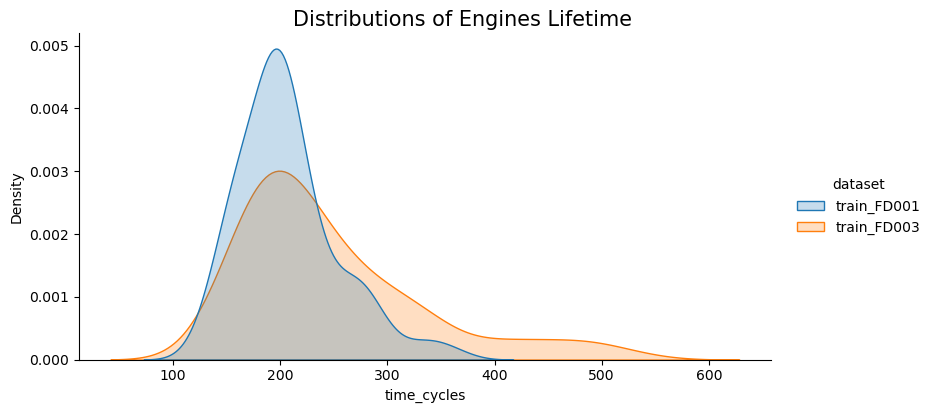

In [11]:
ax = sns.displot(
    data=units_lifetime_train[units_lifetime_train['set'] == 'train'],
    x='time_cycles',
    hue='dataset',
    kind='kde',
    fill=True,
    common_norm=True,
    height=4,
    aspect=2
)
ax.figure.suptitle('Distributions of Engines Lifetime', y=1.02, size=15);

# Looking at the test set now 

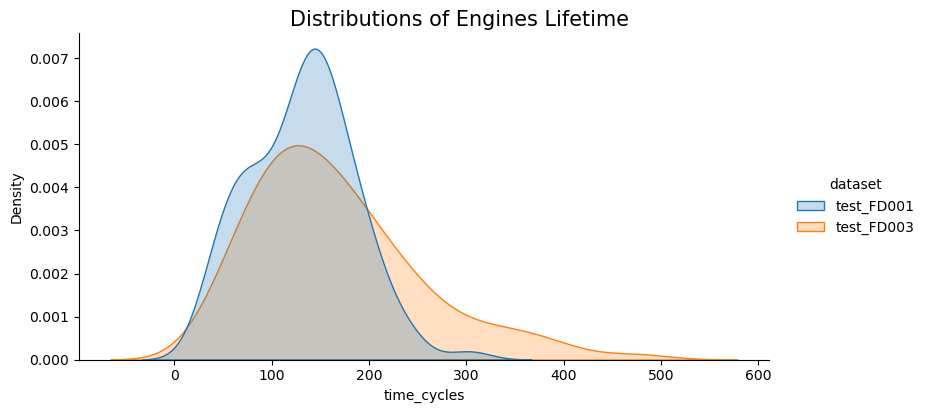

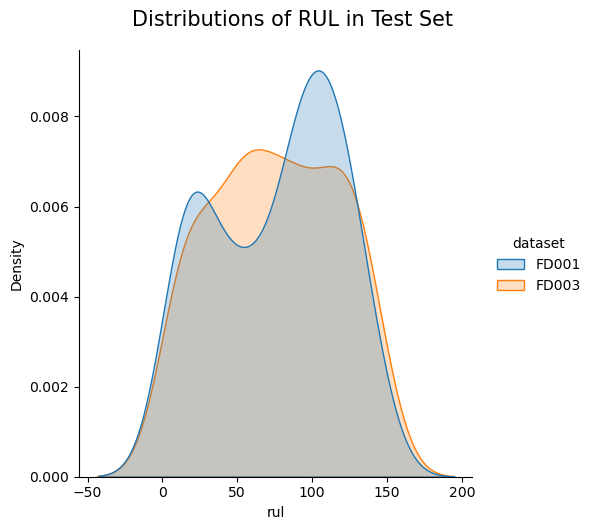

In [12]:
test_units_lifetime = test.groupby(['dataset', 'unit'])['time_cycles'].max().reset_index()
test_units_lifetime['dataset'] = 'test_' + test_units_lifetime['dataset']
test_units_lifetime['set'] = 'test'
units_lifetime_test = pd.concat([train_units_lifetime, test_units_lifetime], ignore_index=True)
units_lifetime_test.groupby('dataset')['time_cycles'].describe()
ax = sns.displot(
    data=units_lifetime_test[units_lifetime_test['set'] == 'test'],
    x='time_cycles',
    hue='dataset',
    kind='kde',
    fill=True,
    common_norm=False,
    height=4,
    aspect=2
)
ax.figure.suptitle('Distributions of Engines Lifetime', y=1.02, size=15);




ax = sns.displot(
    data=test_rul,
    x='rul',
    hue='dataset',
    kind='kde',
    fill=True,
    common_norm=False,
)

ax.figure.suptitle('Distributions of RUL in Test Set', y=1.05, size=15);

Text(0.5, 1.02, 'Distributions of Engine Lifetime (Train vs Test)')

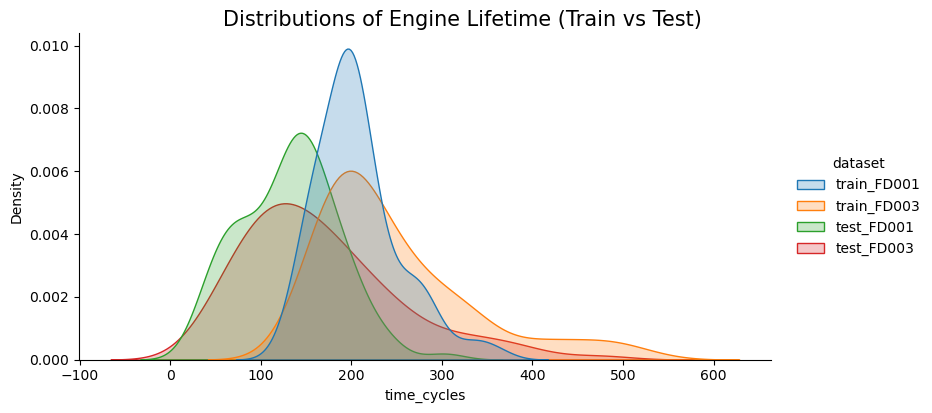

In [13]:
# Compute train unit lifetimes
train_units_lifetime = train.groupby(['dataset', 'unit'])['time_cycles'].max().reset_index()
train_units_lifetime['dataset'] = 'train_' + train_units_lifetime['dataset']
train_units_lifetime['set'] = 'train'

# Compute test unit lifetimes
test_units_lifetime = test.groupby(['dataset', 'unit'])['time_cycles'].max().reset_index()
test_units_lifetime['dataset'] = 'test_' + test_units_lifetime['dataset']
test_units_lifetime['set'] = 'test'

# Combine train and test
units_lifetime_all = pd.concat([train_units_lifetime, test_units_lifetime], ignore_index=True)

# Plot KDE of lifetimes for both sets
ax = sns.displot(
    data=units_lifetime_all,
    x='time_cycles',
    hue='dataset',  # Use 'set' to distinguish between train and test
    kind='kde',
    fill=True,
    common_norm=False,
    height=4,
    aspect=2
)
ax.figure.suptitle('Distributions of Engine Lifetime (Train vs Test)', y=1.02, size=15)


# Take away 

**Train sets - Observations:**

FD00{1} AVG lifetime - 206 cycles and MAX - 378 
FD00{3} AVG lifetime - 245 cycles and MAX - 543


**Test sets - Observations:**

* there're much more short lifetimes in the test set:
    * almost **50% of units in all the test sets have smaller last time cycle than train sets minimum lifetime**
* test sets lifetimes are shorter, on average, on 70 time cycles compared to the train sets

 # The interesting part of our data is the pattern of degradation 

**WE WILL FOCUS ONLY ON FD001 AND FD003 IN THIS SECTION**

In [14]:
def plot_all_units_per_dataset(df, columns=SENSOR_COLUMNS):
    # Only select FD001 and FD003
    selected_datasets = ['FD001', 'FD003']
    datasets = [d for d in df['dataset'].unique() if d in selected_datasets]

    fig, ax = plt.subplots(len(columns), len(datasets), figsize=(6 * len(datasets), 3 * len(columns)))

    for i, dataset_name in enumerate(datasets):
        dataset_df = df[df['dataset'] == dataset_name]
        for j, sensor in enumerate(columns):
            dataset_df.pivot(index='time_cycles', columns='unit', values=sensor) \
                .plot(ax=ax[j, i], legend=None, alpha=0.5)
            ax[j, i].set_title(f'{dataset_name} - {sensor}', fontsize=10)
            ax[j, i].grid(color='grey', linewidth=0.3)

    fig.tight_layout()
    plt.show()

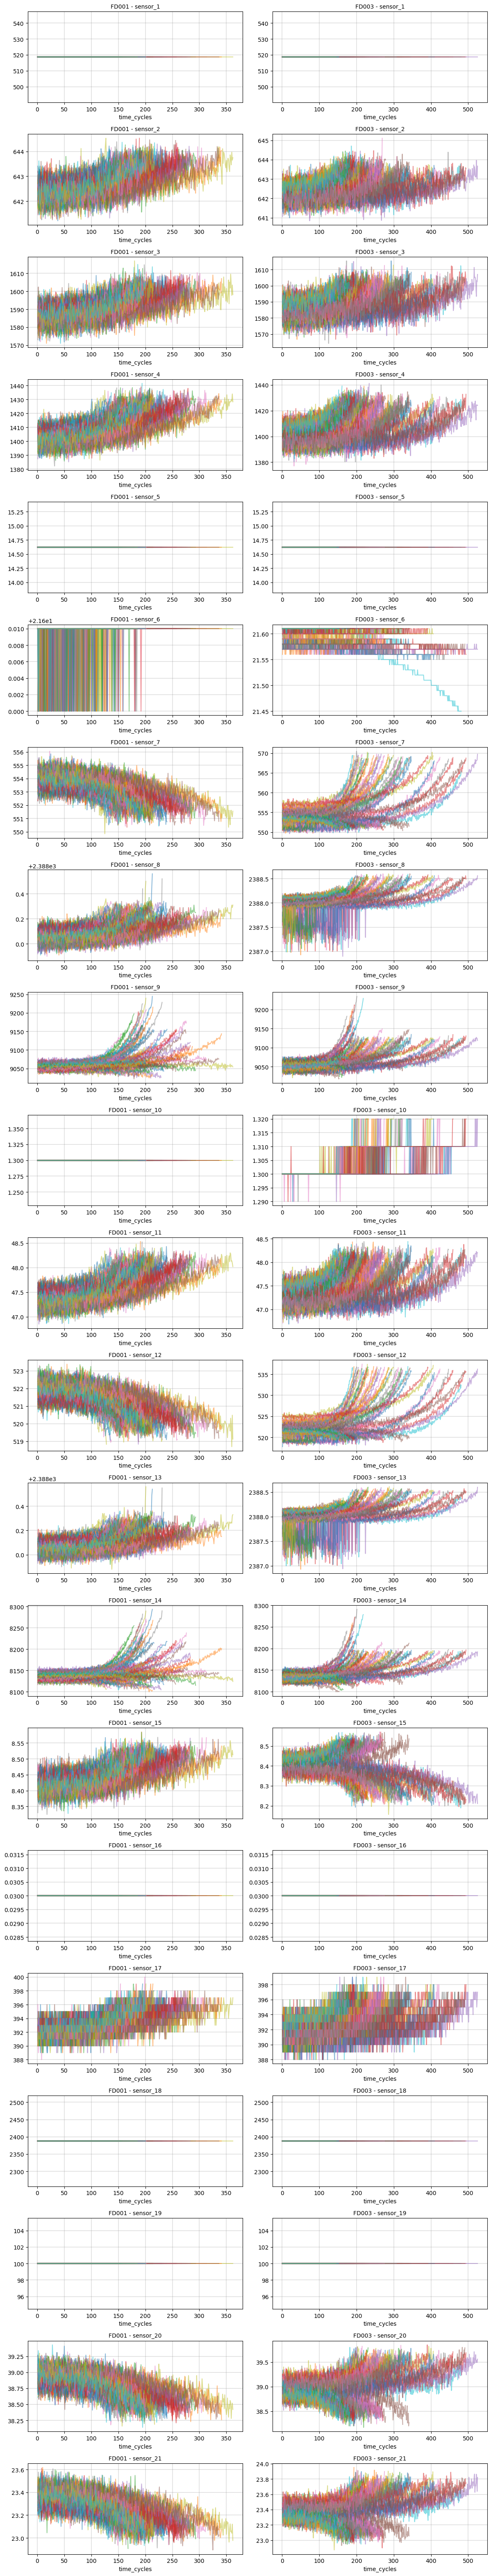

In [15]:
plot_all_units_per_dataset(train)

# Take away 

**Observations:**

* The pattern of increasing or decreasing is clear.
* some sensors time series are constant.
* sensors noise should be considered.
* The sensors are not normalized/scaled 

In [16]:
def plot_all_units(df, dataset_name, columns=SENSOR_COLUMNS):
    if dataset_name not in ['FD001', 'train_FD001', 'test_FD001',
                            'FD003', 'train_FD003', 'test_FD003']:
        print(f"Skipping dataset '{dataset_name}' – only FD001 and FD003 are allowed.")
        return

    dataset_df = df[df['dataset'] == dataset_name]
    for sensor in columns:
        fig, ax = plt.subplots(figsize=(16, 8))
        dataset_df.pivot(index='time_cycles', columns='unit', values=sensor) \
            .plot(ax=ax, legend=None, alpha=0.5)
        ax.set_title(f'{dataset_name} - {sensor}, across all units')
        ax.grid(color='grey', linewidth=0.3)
        plt.show()


In [17]:
def plot_unit_sensors_ts(unit, df, features=SENSOR_COLUMNS, dataset_name='train_FD001', per_sensor=False):
    if dataset_name not in ['FD001', 'train_FD001', 'test_FD001',
                            'FD003', 'train_FD003', 'test_FD003']:
        print(f"Skipping dataset '{dataset_name}' – only FD001 and FD003 are allowed.")
        return

    unit_df = df[(df['unit'] == unit) & (df['dataset'] == dataset_name)]
    unit_df.index = unit_df['time_cycles']
    unit_df = unit_df[features]

    # Scale sensor data
    scaler = StandardScaler()
    unit_sensor_sc = pd.DataFrame(scaler.fit_transform(unit_df), columns=features)

    # Plot all scaled sensors
    fig, ax = plt.subplots(figsize=(14, 6))
    unit_sensor_sc.plot(ax=ax)
    ax.grid(color='grey', linewidth=0.3)
    ax.set_title(f'{dataset_name}, Unit: {unit} (scaled sensor measurements)', loc='left')
    plt.show()

    # plot each sensor separately (raw values)
    if per_sensor:
        for sensor in features:
            fig, ax = plt.subplots(figsize=(16, 6))
            unit_df[sensor].plot(ax=ax, label=sensor)
            ax.legend()
            ax.grid(color='grey', linewidth=0.3)
            ax.set_title(f'{dataset_name}, Unit: {unit} - {sensor}', loc='left')
            plt.show()


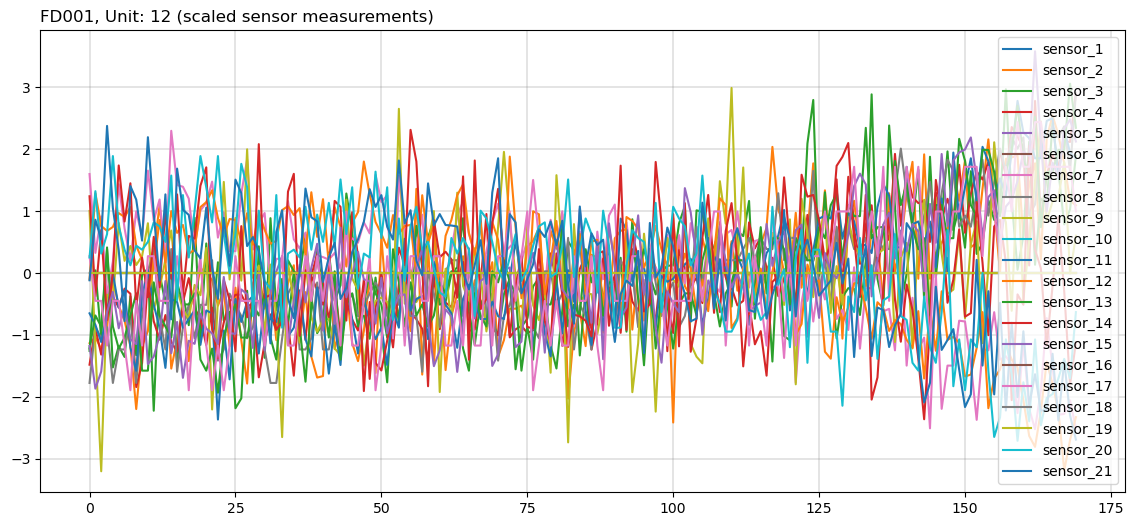

In [18]:
#plot_all_units(df=train, dataset_name='FD001')
plot_unit_sensors_ts(unit=12, df=train, dataset_name='FD001', per_sensor=False)


#  We have to scale the sensors time series with respect to start of every individual engines time series

In [19]:

# Define the dataset names you want to include
DATASET_NAMES = ['FD001', 'FD003']

# Sensors you're interested in
SELECTED_SENSORS = [
    'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14'
]

# Subset and sort
train_sc = train[train['dataset'].isin(DATASET_NAMES)].reset_index(drop=True)
train_sc = train_sc.sort_values(['dataset', 'unit', 'time_cycles']).reset_index(drop=True)
train_sc

unit  time_cycles  op_setting_1  op_setting_2  op_setting_3  sensor_1   
0         1            1       -0.0007       -0.0004         100.0    518.67  \
1         1            2        0.0019       -0.0003         100.0    518.67   
2         1            3       -0.0043        0.0003         100.0    518.67   
3         1            4        0.0007        0.0000         100.0    518.67   
4         1            5       -0.0019       -0.0002         100.0    518.67   
...     ...          ...           ...           ...           ...       ...   
45346   100          148       -0.0016       -0.0003         100.0    518.67   
45347   100          149        0.0034       -0.0003         100.0    518.67   
45348   100          150       -0.0016        0.0004         100.0    518.67   
45349   100          151       -0.0023        0.0004         100.0    518.67   
45350   100          152        0.0000        0.0003         100.0    518.67   

       sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  sensor_14   
0        641.82   1589.70   1400.60     14.62  ...    2388.02    8138.62  \
1        642.15   1591.82   1403.14     14.62  ...    2388.07    8131.49   
2        642.35   1587.99   1404.20     14.62  ...    2388.03    8133.23   
3        642.35   1582.79   1401.87     14.62  ...    2388.08    8133.83   
4        642.37   1582.85   1406.22     14.62  ...    2388.04    8133.80   
...         ...       ...       ...       ...  ...        ...        ...   
45346    643.78   1596.01   1424.11     14.62  ...    2388.30    8138.08   
45347    643.29   1596.38   1429.14     14.62  ...    2388.28    8144.36   
45348    643.84   1604.53   1431.41     14.62  ...    2388.24    8135.95   
45349    643.94   1597.56   1426.57     14.62  ...    2388.26    8141.24   
45350    643.64   1599.04   1436.06     14.62  ...    2388.24    8136.98   

       sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20   
0         8.4195       0.03        392       2388      100.0      39.06  \
1         8.4318       0.03        392       2388      100.0      39.00   
2         8.4178       0.03        390       2388      100.0      38.95   
3         8.3682       0.03        392       2388      100.0      38.88   
4         8.4294       0.03        393       2388      100.0      38.90   
...          ...        ...        ...        ...        ...        ...   
45346     8.5036       0.03        394       2388      100.0      38.44   
45347     8.5174       0.03        395       2388      100.0      38.50   
45348     8.5223       0.03        396       2388      100.0      38.39   
45349     8.5148       0.03        395       2388      100.0      38.31   
45350     8.5150       0.03        396       2388      100.0      38.56   

       sensor_21  dataset  
0        23.4190    FD001  
1        23.4236    FD001  
2        23.3442    FD001  
3        23.3739    FD001  
4        23.4044    FD001  
...          ...      ...  
45346    22.9631    FD003  
45347    22.9746    FD003  
45348    23.0682    FD003  
45349    23.0753    FD003  
45350    23.0847    FD003  

[45351 rows x 27 columns]


========= If we don't scale this is what we got =========


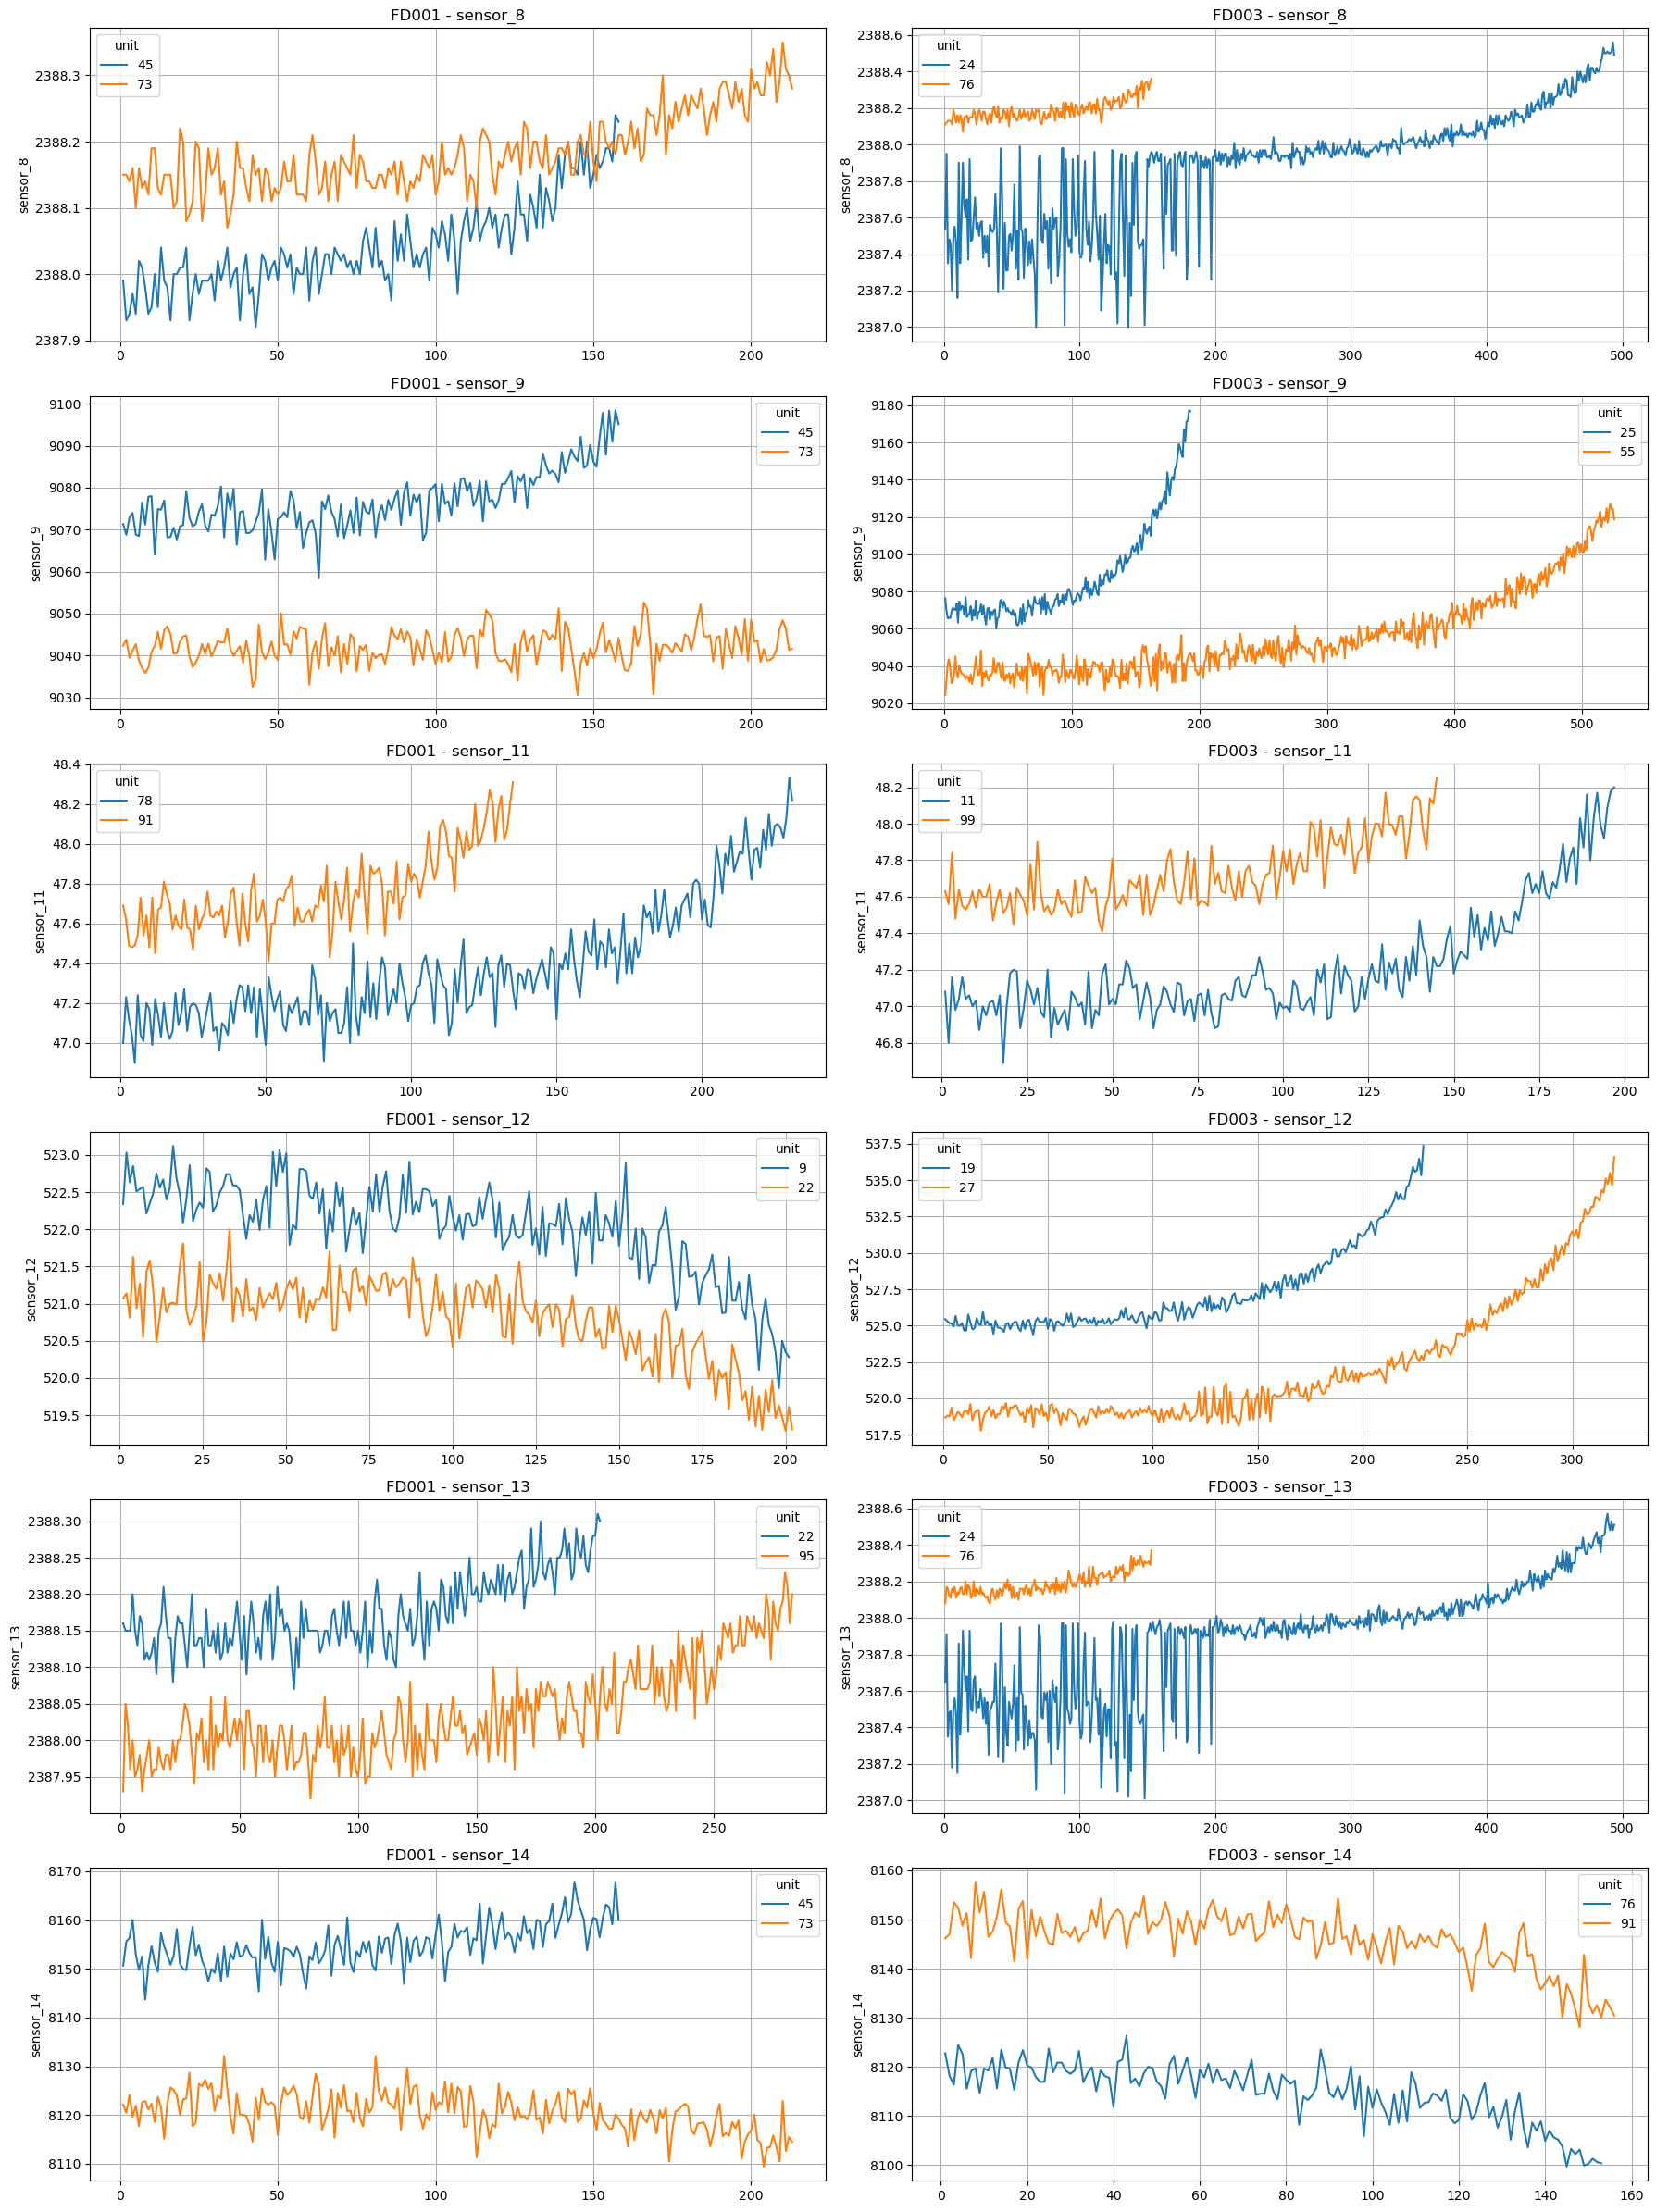

In [20]:

# Compute mean of first 20 cycles for each unit
first_avg_values = (
    train_sc[train_sc['time_cycles'] <= 20]
    .groupby(by=['dataset', 'unit'])[SELECTED_SENSORS]
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(len(SELECTED_SENSORS), len(DATASET_NAMES), figsize=(18, 24))

for i, dataset in enumerate(DATASET_NAMES):
    for j, sensor in enumerate(SELECTED_SENSORS):
        avg_sorted = first_avg_values[first_avg_values['dataset'] == dataset].sort_values(sensor)
        
        
        engine_a, engine_b = avg_sorted['unit'].iloc[0], avg_sorted['unit'].iloc[-1]

        plot_data = train_sc[
            (train_sc['dataset'] == dataset) &
            (train_sc['unit'].isin([engine_a, engine_b]))
        ]

        sns.lineplot(
            data=plot_data,
            x='time_cycles', y=sensor, hue='unit', palette='tab10',
            ax=ax[j, i]
        )
        ax[j, i].set_xlabel('')
        ax[j, i].set_title(f'{dataset} - {sensor}')
        ax[j, i].grid()

print("\n========= If we don't scale this is what we got =========")
fig.tight_layout()
fig.show()


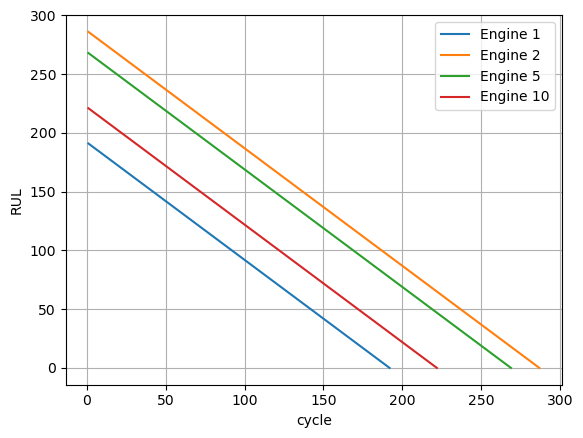

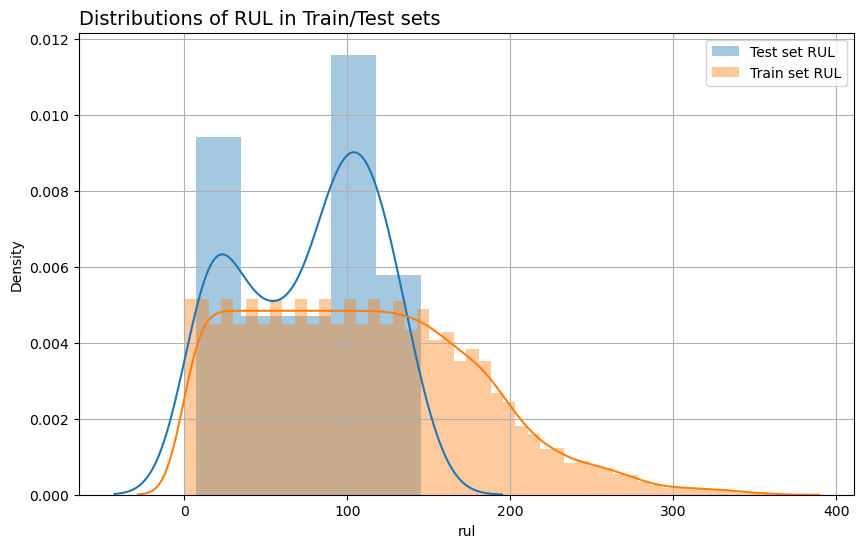

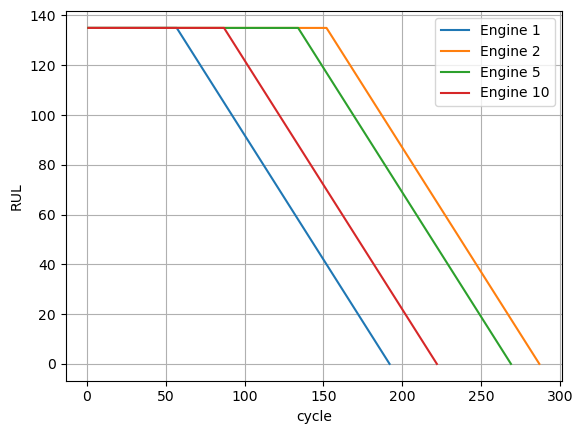

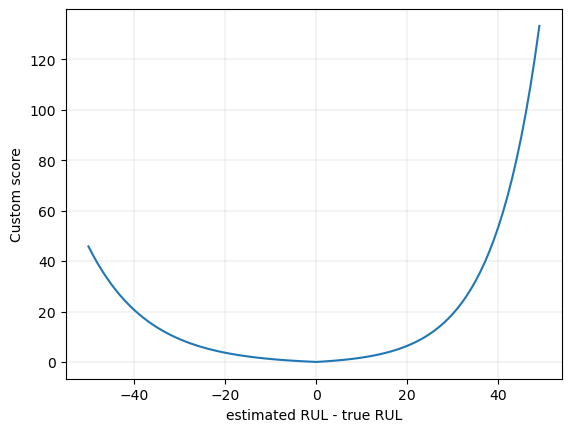


========= If we scale this is what we got =========


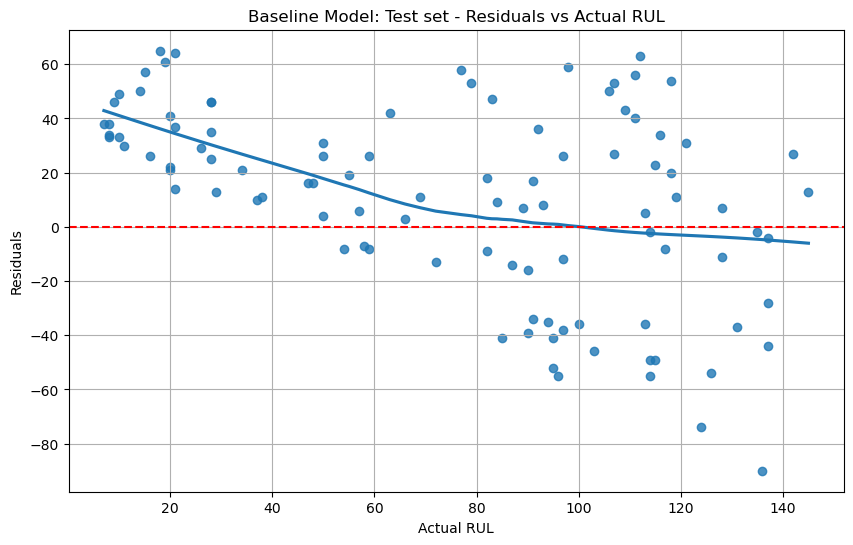

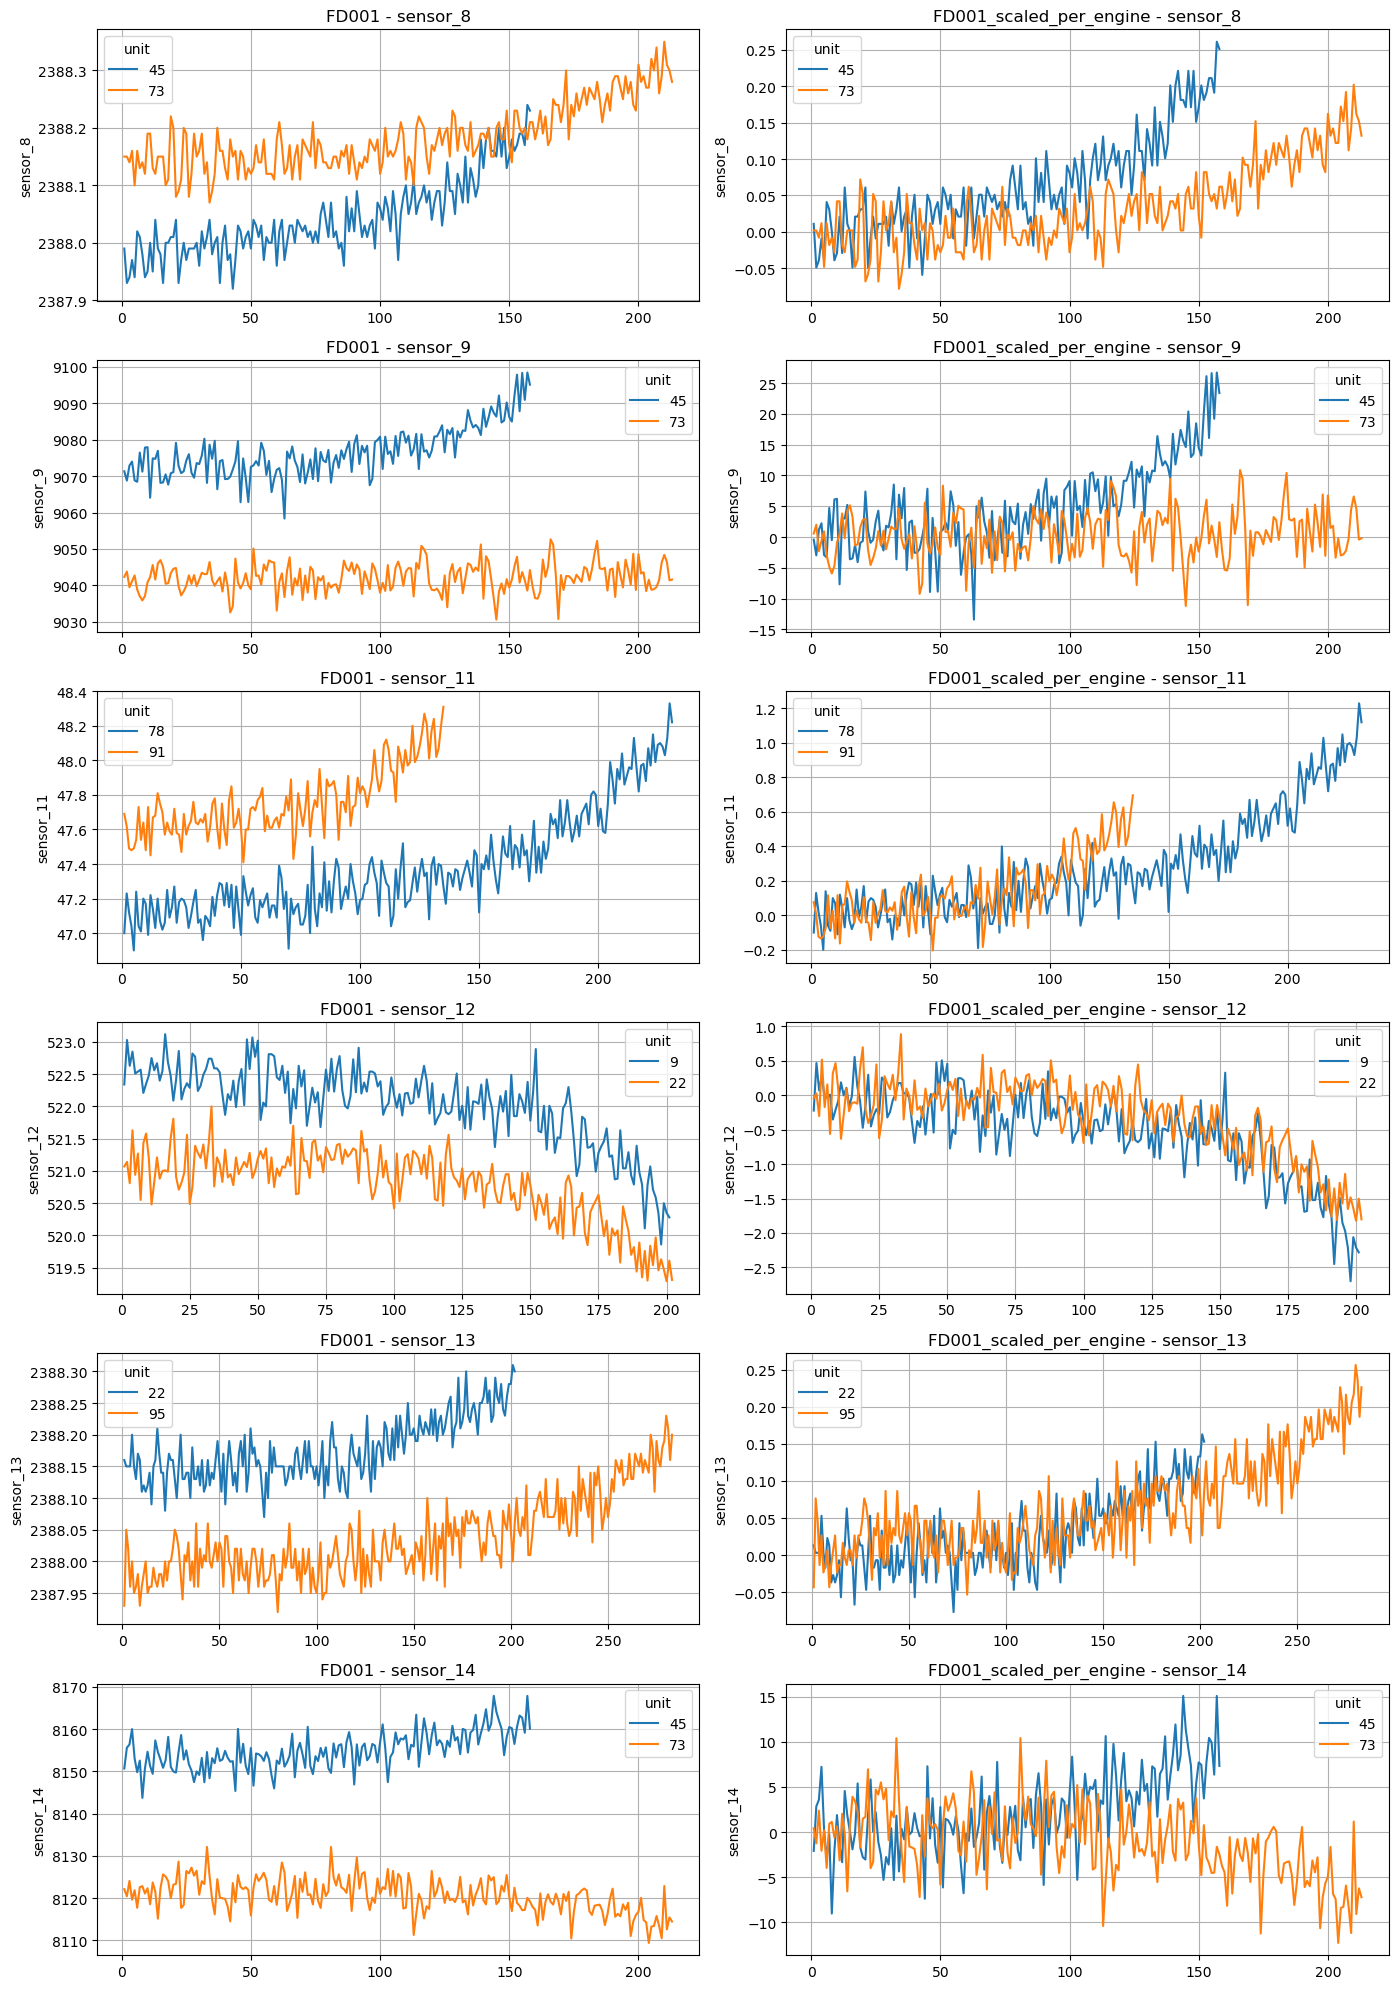

In [21]:
from data_processing import scale_by_engine


# Step 1: Filter and scale FD001
fd001_raw = train_sc[train_sc['dataset'] == 'FD001'].copy()
fd001_scaled = scale_by_engine(fd001_raw, n_first_cycles=20, sensor_columns=SELECTED_SENSORS)

# Step 2: Add a label so plotting works
fd001_scaled['dataset'] = 'FD001'  # To match the filtering used in the plot

# Step 3: Same plotting logic
dataset = 'FD001'
datasets_info = ['FD001', 'FD001_scaled_per_engine']
fig, ax = plt.subplots(len(SELECTED_SENSORS), 2, figsize=(14, 20))

for j, sensor in enumerate(SELECTED_SENSORS):
    avg_sorted = (
        first_avg_values[first_avg_values['dataset'] == dataset]
        .sort_values(sensor)
    )
    engine_a, engine_b = avg_sorted['unit'].iloc[0], avg_sorted['unit'].iloc[-1]

    for i, df in enumerate([fd001_raw, fd001_scaled]):
        sns.lineplot(
            data=df[
                (df['dataset'] == dataset) &
                (df['unit'].isin([engine_a, engine_b]))
            ],
            x='time_cycles', y=sensor, hue='unit', palette='tab10', ax=ax[j, i]
        )
        ax[j, i].set_xlabel('')
        ax[j, i].set_title(f'{datasets_info[i]} - {sensor}')
        ax[j, i].grid()

print("\n========= If we scale this is what we got =========")
fig.tight_layout()
fig.show()




---

# Conclusion

Through this exploratory analysis, we gained a solid understanding of the FD001 and FD003 datasets from C-MAPSS. We saw that many sensor signals show clear signs of degradation over time, which is crucial for predicting Remaining Useful Life (RUL). However, these patterns are often hidden by noise, engine-to-engine differences, and varying starting conditions.

To tackle this, we scaled each engine’s sensor data based on the average of its early cycles. This helped bring out the degradation trends more clearly and made comparisons across engines more meaningful.

By focusing on FD001 and FD003 two datasets with simpler and more consistent setups, we’ve created a strong starting point for modeling. These findings will directly inform how we choose features, process the data, and build our models moving forward.